In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from tensorflow import keras
from sklearn import tree
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('diabetes_prediction_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [3]:
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


## Data cleaning:
- Removal of gender "other" and smoking "no info" due to lack of clarity on actual values (e.g. transgender, decline to state, etc).  Entries would likely not provide insight for feature correlation to category outcome.
- Conversion of gender and smoking history to numeric values using dictionary

In [4]:
dataValDict = {'gender': {'Male': 0, 'Female': 1, 'Other': 3}, 'smoking_history': {'never': 0, 'current': 1, 'ever': 2, 'former': 3, 'not current': 4}}

#Original file is saved as original data.  Df will be 'cleaned' file.
df = data[data['gender'] != 'Other']
df = data[data['smoking_history'] != 'No Info']

df = df.replace(dataValDict)
df['gender'] = pd.to_numeric(df['gender'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64184 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               64184 non-null  int64  
 1   age                  64184 non-null  float64
 2   hypertension         64184 non-null  int64  
 3   heart_disease        64184 non-null  int64  
 4   smoking_history      64184 non-null  int64  
 5   bmi                  64184 non-null  float64
 6   HbA1c_level          64184 non-null  float64
 7   blood_glucose_level  64184 non-null  int64  
 8   diabetes             64184 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.9 MB


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80.0,0,1,0,25.19,6.6,140,0
2,0,28.0,0,0,0,27.32,5.7,158,0
3,1,36.0,0,0,1,23.45,5.0,155,0
4,0,76.0,1,1,1,20.14,4.8,155,0
5,1,20.0,0,0,0,27.32,6.6,85,0
...,...,...,...,...,...,...,...,...,...
99992,1,26.0,0,0,0,34.34,6.5,160,0
99993,1,40.0,0,0,0,40.69,3.5,155,0
99997,0,66.0,0,0,3,27.83,5.7,155,0
99998,1,24.0,0,0,0,35.42,4.0,100,0


## Training and Test set creation:

In [5]:
#Split features from (diabetes) label

features = ['gender','age','hypertension','heart_disease','smoking_history', 'bmi','HbA1c_level','blood_glucose_level']

df_check_ensemble = df.sample(5000)
df = df.drop(df_check_ensemble.index)


X = df.loc[:, features]
y = df.loc[:, ['diabetes']]

X_check_ensemble = df_check_ensemble.loc[:, features]
y_check_ensemble = df_check_ensemble.loc[:, ['diabetes']]
#Data will be shuffled before split by default. No stratification. Test size = 30% of set.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .70)
X_train.shape, X_test.shape

((41428, 8), (17756, 8))

In [6]:
#Create np array versions of test and train data
X_trn_np = X_train.to_numpy() 
X_tst_np = X_test.to_numpy() 
y_trn_np = y_train.to_numpy() 
y_tst_np = y_test.to_numpy() 

## Keras Neural Network

In [7]:
#LOAD NEXT CELL INSTEAD, LOADS PRE-TRAINED NEURAL NET
#This neural network can take up to 5 minutes or more to train depending on hardware

activation_type = 'relu'

NNModel = keras.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation=activation_type, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation=activation_type),
    keras.layers.Dense(64, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation=activation_type),
    keras.layers.Dense(32, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation=activation_type, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(16, activation=activation_type, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(16, activation=activation_type),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(8, activation=activation_type, kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(8, activation=activation_type),
    keras.layers.Dense(1)
])

#Start with moderate level of learning rate which we will adjust later
optimizer = keras.optimizers.Adam(learning_rate=0.001)

#Use Binary Focal Crossentropy instead of Binary Crossentropy as the prevalence of diabetes vs. not having diabetes is not symmetrical
NNModel.compile(optimizer=optimizer, loss=keras.losses.BinaryFocalCrossentropy(from_logits=True), metrics=['accuracy'])

#Add two callbacks, the first ends training early if 25 epocsh go by without improvement on the validation set
#The second callback adjusts the learning rate if 5 epochs go by without improvement on the validation set
callbacks = []
callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=25))
callbacks.append(keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5))

#Train over 250 epochs (maximum), using a moderate batch size to improve training times
NNModel.fit(X_train, y_train, epochs=250, batch_size=50, validation_split=0.1, callbacks=callbacks)

evaluation = NNModel.evaluate(X_test, y_test, batch_size = 1)
print(evaluation[1])


Epoch 1/250
746/746 [==============================] - 5s 3ms/step - loss: 0.1968 - accuracy: 0.8905 - val_loss: 0.0537 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 2/250
746/746 [==============================] - 2s 3ms/step - loss: 0.0505 - accuracy: 0.8905 - val_loss: 0.0473 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 3/250
746/746 [==============================] - 2s 3ms/step - loss: 0.0469 - accuracy: 0.8905 - val_loss: 0.0420 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 4/250
746/746 [==============================] - 3s 4ms/step - loss: 0.0452 - accuracy: 0.9137 - val_loss: 0.0436 - val_accuracy: 0.9273 - lr: 0.0010
Epoch 5/250
746/746 [==============================] - 2s 3ms/step - loss: 0.0433 - accuracy: 0.9396 - val_loss: 0.0466 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 6/250
746/746 [==============================] - 2s 3ms/step - loss: 0.0426 - accuracy: 0.9418 - val_loss: 0.0384 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 7/250
746/746 [==============================] - 2s 3ms/st

In [8]:
#NNModel.save('DanielNeuralNetworkModel.keras')
#loaded_NNmodel = keras.models.load_model('DanielNeuralNetworkModel.keras')
loaded_NNmodel = NNModel

NN_predictions = loaded_NNmodel.predict(([X_test]))
NN_probabilities = 1 / (1 + np.exp(-NN_predictions))
NN_check_class_predictions = [1 if prob >= 0.5 else 0 for prob in NN_probabilities]


NN_accuracy = []
NN_f1 = []
NN_precision = []
NN_recall = []

NN_accuracy.append(accuracy_score(y_test, NN_check_class_predictions))
NN_f1.append(f1_score(y_test, NN_check_class_predictions))
NN_precision.append(precision_score(y_test, NN_check_class_predictions))
NN_recall.append(recall_score(y_test, NN_check_class_predictions))


NN_check_predictions = loaded_NNmodel.predict(([X_check_ensemble]))
NN_check_probabilities = 1 / (1 + np.exp(-NN_check_predictions))

print(NN_check_probabilities)

157/157 [==============================] - 0s 847us/step
[[0.1951512 ]
 [0.3106592 ]
 [0.06308005]
 ...
 [0.04888947]
 [0.04189446]
 [0.025401  ]]


In [9]:
print("NN classification report:\n")
target_names = ['Negative', 'Positive']
confusion_nn = classification_report(y_test, NN_check_class_predictions, target_names = target_names)
print(confusion_nn)

NN classification report:

              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98     15791
    Positive       0.96      0.66      0.78      1965

    accuracy                           0.96     17756
   macro avg       0.96      0.83      0.88     17756
weighted avg       0.96      0.96      0.96     17756



## MLP Neural Network

In [10]:
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .3)
MLPmodel = MLPClassifier()
cv = cross_val_score(MLPmodel, X_train, y_train, cv=5)
MLPmodel.fit(X_train, y_train)
test_accuracy = MLPmodel.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9501576931741383


In [ ]:
#This MLP grid search can take up to 2 hours or more to train depending on hardware
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'solver' : ['sgd', 'adam'],
    'activation' : ['identity', 'logistic', 'relu'],
    'max_iter': [200, 500, 1000],
    'learning_rate': ['constant','invscaling','adaptive']}
grid_search = GridSearchCV(MLPmodel, param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_mlp = grid_search.best_estimator_
gridmodel_acc = best_mlp.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

In [11]:
tuned_MLP_model = MLPClassifier(activation = 'logistic', hidden_layer_sizes = (100,50), learning_rate = 'adaptive', max_iter = 1000, solver = 'adam')
cv = cross_val_score(tuned_MLP_model, X_train, y_train, cv=5)
tuned_MLP_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),
              learning_rate='adaptive', max_iter=1000)

In [12]:
y_pred_MLP = tuned_MLP_model.predict(X_test)

MLP_accuracy = (accuracy_score(y_test, y_pred_MLP))
MLP_f1 = (f1_score(y_test, y_pred_MLP))
MLP_precision = (precision_score(y_test, y_pred_MLP))
MLP_recall = (recall_score(y_test, y_pred_MLP))

MLP_check_probabilities = (tuned_MLP_model.predict_proba(X_check_ensemble))[:,1]
print(MLP_check_probabilities)

[0.00232727 0.05448813 0.02000068 ... 0.02209799 0.0010009  0.00625713]


In [13]:
print("MLP classification report:\n")
target_names = ['Negative', 'Positive']
confusion_nn = classification_report(y_test, y_pred_MLP, target_names = target_names)
print(confusion_nn)

MLP classification report:

              precision    recall  f1-score   support

    Negative       0.95      1.00      0.97     15791
    Positive       0.96      0.60      0.74      1965

    accuracy                           0.95     17756
   macro avg       0.96      0.80      0.86     17756
weighted avg       0.95      0.95      0.95     17756



## Logistic Regression

In [14]:
#This LR grid search can take up to 5 minutes or more to train depending on hardware

param_grid = [
    # For sag solver 
    {
        'penalty': ['l2'],  
        'C': [0.01, 0.1, 1, 10],
        'solver': ['sag'],
        'max_iter': [1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1]}, 

    # Penalty is None
    {
        'penalty': [None], 
        'C': [1], 
        'solver': ['sag', 'saga', 'newton-cg', 'lbfgs'],
        'max_iter': [1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1]},

    # For saga solver 
    {
        'penalty': ['l1', 'l2'], 
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'max_iter': [1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1]},

    # For saga solver with elasticnet penalty
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'max_iter': [1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1],
        'l1_ratio': [0.1, 0.5, 0.9],
        'tol': [0.01, 0.1]},  

    # For liblinear solver
    {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear'],
        'max_iter': [500, 750, 1000, 1500],
        'multi_class': ['ovr'],
        'tol': [0.01, 0.1]},

    # For lbfgs solver
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs'],
        'max_iter': [500, 750, 1000, 1500],
        'multi_class': ['ovr', 'multinomial'],
        'tol': [0.01, 0.1]}    
    ]

logistic_model = LogisticRegression()
grid_search = GridSearchCV(logistic_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
best_logistic = grid_search.best_estimator_

test_accuracy = best_logistic.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'C': 0.1, 'max_iter': 500, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}
Test Accuracy: 0.9478486145528272


Test Accuracy: 0.948073890515882
Coefficients: [[-0.28051713  0.04985235  0.69128712  0.60890262 -0.00800968  0.09004515
   2.25261568  0.03284531]]


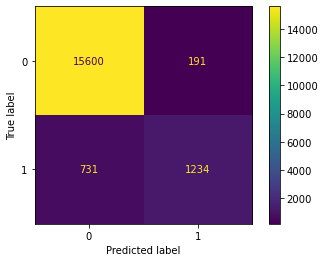

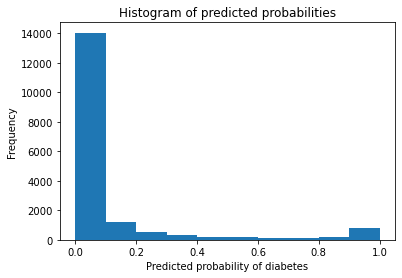

In [15]:
# Initializing and training the Logistic Regression model
tuned_LR_model = LogisticRegression(C = 0.1, max_iter= 1000, multi_class= 'ovr', penalty= 'l2', solver= 'lbfgs', tol= 0.01)
cv_scores = cross_val_score(tuned_LR_model, X_train, y_train, cv=5)
tuned_LR_model.fit(X_train, y_train)
LR_test_accuracy = tuned_LR_model.score(X_test, y_test)
print("Test Accuracy:", LR_test_accuracy)
print('Coefficients:', tuned_LR_model.coef_)

ConfusionMatrixDisplay.from_estimator(tuned_LR_model, X_test, y_test)
plt.show()

y_prob = tuned_LR_model.predict_proba(X_test)
plt.hist(y_prob[:,1], bins=10)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')
plt.show()

In [16]:
y_pred_LR = tuned_LR_model.predict(X_test)

LR_accuracy = accuracy_score(y_test, y_pred_LR)
LR_f1 = f1_score(y_test, y_pred_LR)
LR_precision = precision_score(y_test, y_pred_LR)
LR_recall = recall_score(y_test, y_pred_LR)

LR_check_probabilities = tuned_LR_model.predict_proba(X_check_ensemble)[:,1]
print(LR_check_probabilities[:12])

[1.56034070e-02 4.40484089e-02 4.96615467e-02 1.39256301e-04
 6.31179601e-02 2.31403435e-02 9.55149441e-01 1.78700961e-02
 1.66997273e-01 6.59033299e-02 2.50137537e-02 4.26607094e-01]


In [17]:
print("LR classification report:\n")
target_names = ['Negative', 'Positive']
confusion_LR = classification_report(y_test, y_pred_LR, target_names = target_names)
print(confusion_LR)

LR classification report:

              precision    recall  f1-score   support

    Negative       0.96      0.99      0.97     15791
    Positive       0.87      0.63      0.73      1965

    accuracy                           0.95     17756
   macro avg       0.91      0.81      0.85     17756
weighted avg       0.95      0.95      0.94     17756



## Random Forest

Accuracy:  0.9594503266501464
[[15705    86]
 [  634  1331]]


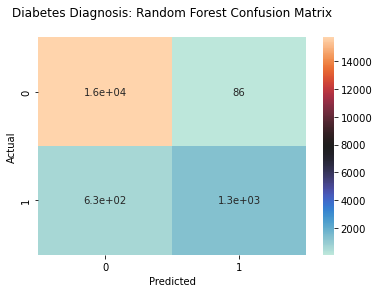

              precision    recall  f1-score   support

    Negative       0.96      0.99      0.98     15791
    Positive       0.94      0.68      0.79      1965

    accuracy                           0.96     17756
   macro avg       0.95      0.84      0.88     17756
weighted avg       0.96      0.96      0.96     17756



In [18]:
y_trn_np = y_train.to_numpy()
y_trn_np_ravel = y_train.to_numpy().ravel()
forest = RandomForestClassifier()

#Fit to training data and labels
forest.fit(X_train, y_trn_np_ravel)

#Predict results and generate confusion matrix
forest_predicted = forest.predict(X_test)
forest.score(X_test, y_test)
accuracy = accuracy_score(y_test, forest_predicted)
print("Accuracy: ", accuracy)


confusion = confusion_matrix(y_test, forest_predicted)
print(confusion)
sns.heatmap(confusion, cmap = 'icefire', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Diabetes Diagnosis: Random Forest Confusion Matrix\n')
plt.show()

#Print classification report
target_names = ['Negative', 'Positive']
print(classification_report(y_test, forest_predicted, target_names = target_names))


In [19]:
def Best_Fit_Randomized(method, param_distributions, X_train, y_train, X_test, y_test):
    rand_search_method = RandomizedSearchCV(method, param_distributions=param_distributions, n_iter=30, verbose=1)
    best_fit = rand_search_method.fit(X_train, y_train)
    predicted = best_fit.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    return best_fit, accuracy, predicted, rand_search_method

In [20]:
n_estimators = np.arange(30, 900, 25)
criterion = ['gini', 'entropy']
min_samples_split = np.arange(2, 8, 2)
min_samples_leaf = np.arange(1, 4, 1)
min_weight_fraction_leaf = np.arange(0, 0.5, 0.1)
max_features = ['sqrt', 'log2', None]
min_impurity_decrease = np.arange(0.00005, 0.01, 0.002)
bootstrap = [True, False]
class_weight = [None, 'balanced', 'balanced_subsample']

param_distributions = {'n_estimators':n_estimators, 'criterion':criterion,
                       'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf,
                       'min_weight_fraction_leaf':min_weight_fraction_leaf, 'max_features':max_features,
                       'min_impurity_decrease':min_impurity_decrease,
                       'bootstrap':bootstrap, 'class_weight':class_weight}

In [21]:
forest_opt = RandomForestClassifier()
best_fit_opt, accuracy_opt, predicted_opt, rand_search_opt = Best_Fit_Randomized(forest_opt, param_distributions, X_train, y_trn_np_ravel, X_test, y_test)
best_params_opt = best_fit_opt.best_params_
best_score_opt = best_fit_opt.best_score_
best_estimator_opt = best_fit_opt.best_estimator_
print("best_params", best_params_opt)
print("best_estimator", best_estimator_opt)

print("best_estimator.feature_importances_", best_estimator_opt.feature_importances_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
best_params {'n_estimators': 105, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 6, 'min_samples_leaf': 1, 'min_impurity_decrease': 5e-05, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}
best_estimator RandomForestClassifier(max_features='log2', min_impurity_decrease=5e-05,
                       min_samples_split=6, n_estimators=105)
best_estimator.feature_importances_ [0.0012721  0.04526679 0.01535764 0.00916456 0.00182384 0.03083765
 0.50952034 0.38675708]


Accuracy: 0.9634063404094217
[[15786     5]
 [  663  1302]]


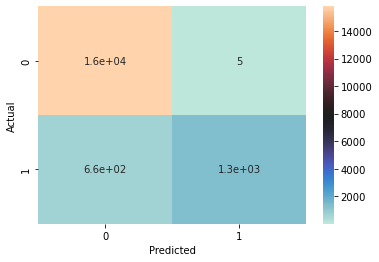

              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98     15791
    Positive       1.00      0.66      0.80      1965

    accuracy                           0.96     17756
   macro avg       0.98      0.83      0.89     17756
weighted avg       0.96      0.96      0.96     17756



In [22]:
print("Accuracy:", best_score_opt)

confusion_opt = confusion_matrix(y_test, predicted_opt)
print(confusion_opt)
sns.heatmap(confusion_opt, cmap = 'icefire', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Print classification report
target_names = ['Negative', 'Positive']
print(classification_report(y_test, predicted_opt, target_names = target_names))

In [23]:
def Sort_Values(unsorted_array):
    pos = 0
    highest = -1
    ordered_array =[]
    pos_array = []
    while(len(ordered_array) < len(unsorted_array)): #Not all values entered
        for i in range(0, len(unsorted_array), 1):
            if(unsorted_array[i] >= highest):
                highest = unsorted_array[i]
                pos = i
        ordered_array.append(highest)
        pos_array.append(pos)
        unsorted_array[pos] = -2 #Ignore position in the future
        highest = -1
        pos = 0
            
    return pos_array, ordered_array

def Make_Pandas_Cols(head1):
    df = pd.DataFrame(columns=head1)
    for row in range(0, len(head1), 1):  #All cols except labels
        column = head1[row]
    
    return df

def Make_Pandas(array1, array2, head1):
    df = Make_Pandas_Cols(head1)
    df.loc["Unoptimized"] = array1
    df.loc["Optimized"] = array2

    return df

In [24]:
#Sort features and importance percentages from highest to lowest for original and optimized

feature_orig = forest.feature_importances_
feature_opt = best_estimator_opt.feature_importances_
pos_array, ordered_array = Sort_Values(feature_orig)
print("Sorted original feature importance\n", pos_array)
print(ordered_array)
pos_array_opt, ordered_array_opt = Sort_Values(feature_opt)
print("Sorted optimized feature importance\n", pos_array)
print(ordered_array_opt)

Sorted original feature importance
 [6, 7, 5, 1, 4, 2, 3, 0]
[0.3923144343855365, 0.3220323949510809, 0.13017253839486076, 0.1009445392530006, 0.02246367882622664, 0.013483977303954595, 0.011510441475729685, 0.007077995409610529]
Sorted optimized feature importance
 [6, 7, 5, 1, 4, 2, 3, 0]
[0.5095203432538233, 0.3867570768992131, 0.04526678935260234, 0.03083765281772122, 0.015357636244718895, 0.009164564368260478, 0.0018238373468372378, 0.0012720997168234572]


In [25]:
headers = []
unopt = []
opt = []
for i in range(0, len(pos_array), 1):
    headers.append(df.columns[pos_array[i]])
    unopt.append(ordered_array[i] * 100)
    opt.append(ordered_array_opt[i] * 100)
    feature_pd = Make_Pandas(unopt, opt, headers)
    feature_pd = feature_pd.round(decimals=4)
    vals = feature_pd.iloc[1]

<BarContainer object of 8 artists>

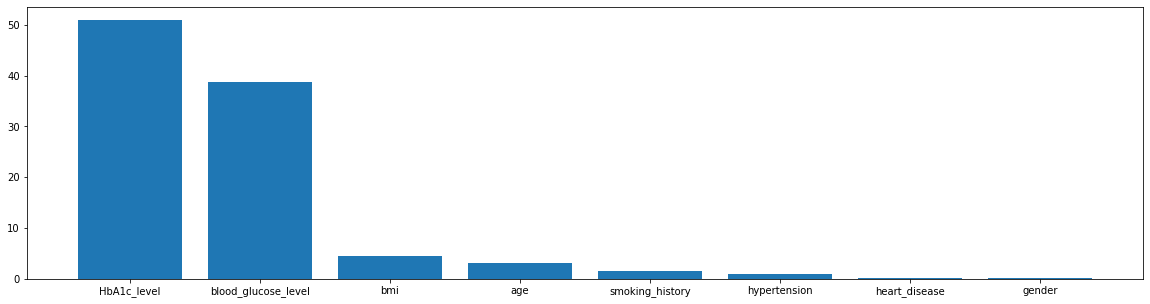

In [26]:
plt.rcParams["figure.figsize"] = (20,5)
plt.title = "Histogram of Feature Relevance to Diabetes Diagnosis"
plt.bar(headers, opt)

In [27]:
Final_Outcome = X_test
Final_Outcome['actual'] = y_test
Final_Outcome['predicted'] = predicted_opt
Final_Outcome

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,actual,predicted
49573,1,25.0,0,0,0,22.77,6.6,145,0,0
75897,1,37.0,0,0,1,23.93,4.5,200,0,0
78113,1,36.0,0,0,0,25.92,5.0,100,0,0
79187,0,39.0,1,0,1,44.81,6.5,280,1,1
97062,1,49.0,0,0,0,27.32,5.7,145,0,0
...,...,...,...,...,...,...,...,...,...,...
13253,1,61.0,0,0,2,40.96,9.0,145,1,1
34358,1,76.0,0,0,0,25.15,5.0,200,0,0
85538,1,30.0,0,0,0,21.69,4.5,159,0,0
63190,1,39.0,0,0,0,23.08,6.6,85,0,0


In [28]:
y_pred_RFC = predicted_opt

RFC_accuracy = accuracy_score(y_test, y_pred_RFC)
RFC_f1 = f1_score(y_test, y_pred_RFC)
RFC_precision = precision_score(y_test, y_pred_RFC)
RFC_recall = recall_score(y_test, y_pred_RFC)

RFC_check_probabilities = best_fit_opt.predict_proba(X_check_ensemble)[:,1]
print(RFC_check_probabilities[:12])

[0.0246675  0.05137965 0.01165849 0.00802165 0.04481254 0.03968438
 1.         0.01469615 0.0538778  0.15069447 0.00978883 0.96704603]


In [29]:
#False negative cases, misdiagnosed as not diabetic
f_neg_df = Final_Outcome.loc[(Final_Outcome['actual'] == 1) & (Final_Outcome['predicted'] == 0)]
f_neg_df = f_neg_df.sort_values(by=['age'])
f_neg_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,actual,predicted
16306,1,14.0,0,0,0,20.87,6.1,126,1,0
60432,1,14.0,0,0,4,27.32,5.8,160,1,0
35266,1,15.0,0,0,0,25.00,6.1,126,1,0
11505,1,17.0,0,0,2,22.90,6.1,130,1,0
74643,1,18.0,0,0,0,28.59,6.2,160,1,0
...,...,...,...,...,...,...,...,...,...,...
7197,1,80.0,0,0,0,31.01,5.7,160,1,0
30133,1,80.0,1,0,0,28.34,6.1,155,1,0
61150,0,80.0,0,0,0,22.63,6.6,155,1,0
16142,1,80.0,1,0,0,27.32,5.8,155,1,0


Normal BMI: 18.5 to 24.9
Evaluated Range BMI:  10.89 to 88.76
False Negative Range BMI:  12.91 to 61.02 

268
Approximate misdiagnoses by BMI: 268


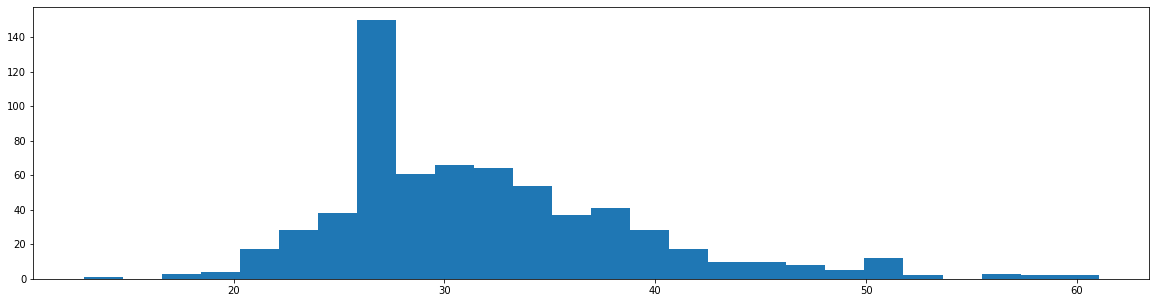

In [30]:
#Print normal ranges and data ranges
print("Normal BMI: 18.5 to 24.9")
print("Evaluated Range BMI: ", Final_Outcome['bmi'].min(), "to", Final_Outcome['bmi'].max())
print("False Negative Range BMI: ", f_neg_df['bmi'].min(), "to", f_neg_df['bmi'].max(), "\n")
pd.set_option('display.max_rows', None)
f_neg_low_bmi = f_neg_df.loc[(f_neg_df['bmi'] <= 30) & (f_neg_df['HbA1c_level'] > 5.7) & (f_neg_df['blood_glucose_level'] > 99)]

f_neg_low_bmi = f_neg_low_bmi.sort_values(by=['bmi'])
print(len(f_neg_low_bmi))
#f_neg_low_bmi

#Create histograms showing number of false negatives by BMI
plt.hist(f_neg_df['bmi'], bins='auto')
print("Approximate misdiagnoses by BMI:", len(f_neg_low_bmi)) 

Normal HbA1c: 4% to 5.6%
Evaluated Range HbA1c_level:  3.5 to 9.0
False Negative Range HbA1c_level:  5.7 to 6.6 

102
Approximate misdiagnoses by HbA1c_level: 102


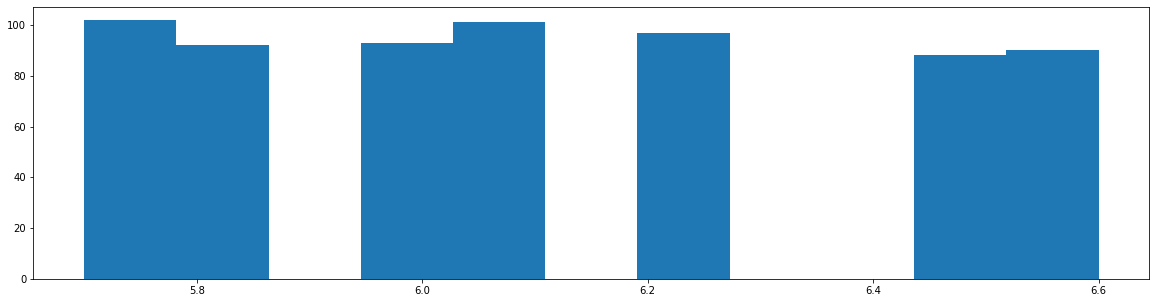

In [31]:
print("Normal HbA1c: 4% to 5.6%")
print("Evaluated Range HbA1c_level: ", Final_Outcome['HbA1c_level'].min(), "to", Final_Outcome['HbA1c_level'].max())
print("False Negative Range HbA1c_level: ", f_neg_df['HbA1c_level'].min(), "to", f_neg_df['HbA1c_level'].max(), "\n")

f_neg_low_hba1c_hi_glucose = f_neg_df.loc[(f_neg_df['HbA1c_level'] <= 5.7)
                                 & (f_neg_df['blood_glucose_level'] > 99)]
print(len(f_neg_low_hba1c_hi_glucose))
#f_neg_low_hba1c_hi_glucose

plt.hist(f_neg_df['HbA1c_level'], bins='auto')

print("Approximate misdiagnoses by HbA1c_level:", len(f_neg_low_hba1c_hi_glucose))

Evaluated Range Age:  0.16 to 80.0
False Negative Range Age:  14.0 to 80.0 

Approximate misdiagnoses by age: 108


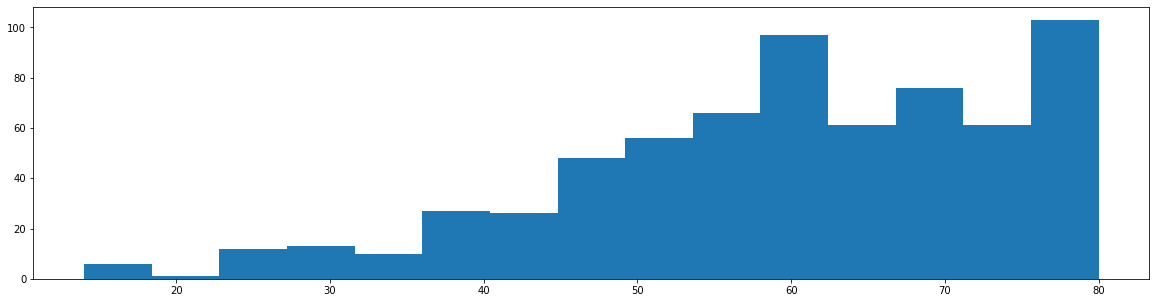

In [32]:
f_neg_low_hba1c_hi_age = f_neg_df.loc[(f_neg_df['age'] > 70) 
                                      & (f_neg_df['HbA1c_level'] >= 5.7)
                                          & (f_neg_df['bmi'] <= 30)]
                                            
#f_neg_low_hba1c_hi_age

print("Evaluated Range Age: ", Final_Outcome['age'].min(), "to", Final_Outcome['age'].max())
print("False Negative Range Age: ", f_neg_df['age'].min(), "to", f_neg_df['age'].max(), "\n")
plt.hist(f_neg_df['age'], bins='auto')

print("Approximate misdiagnoses by age:", len(f_neg_low_hba1c_hi_age))

<class 'list'>
[94, 24, 76, 17, 96, 30, 98, 18, 89, 88]


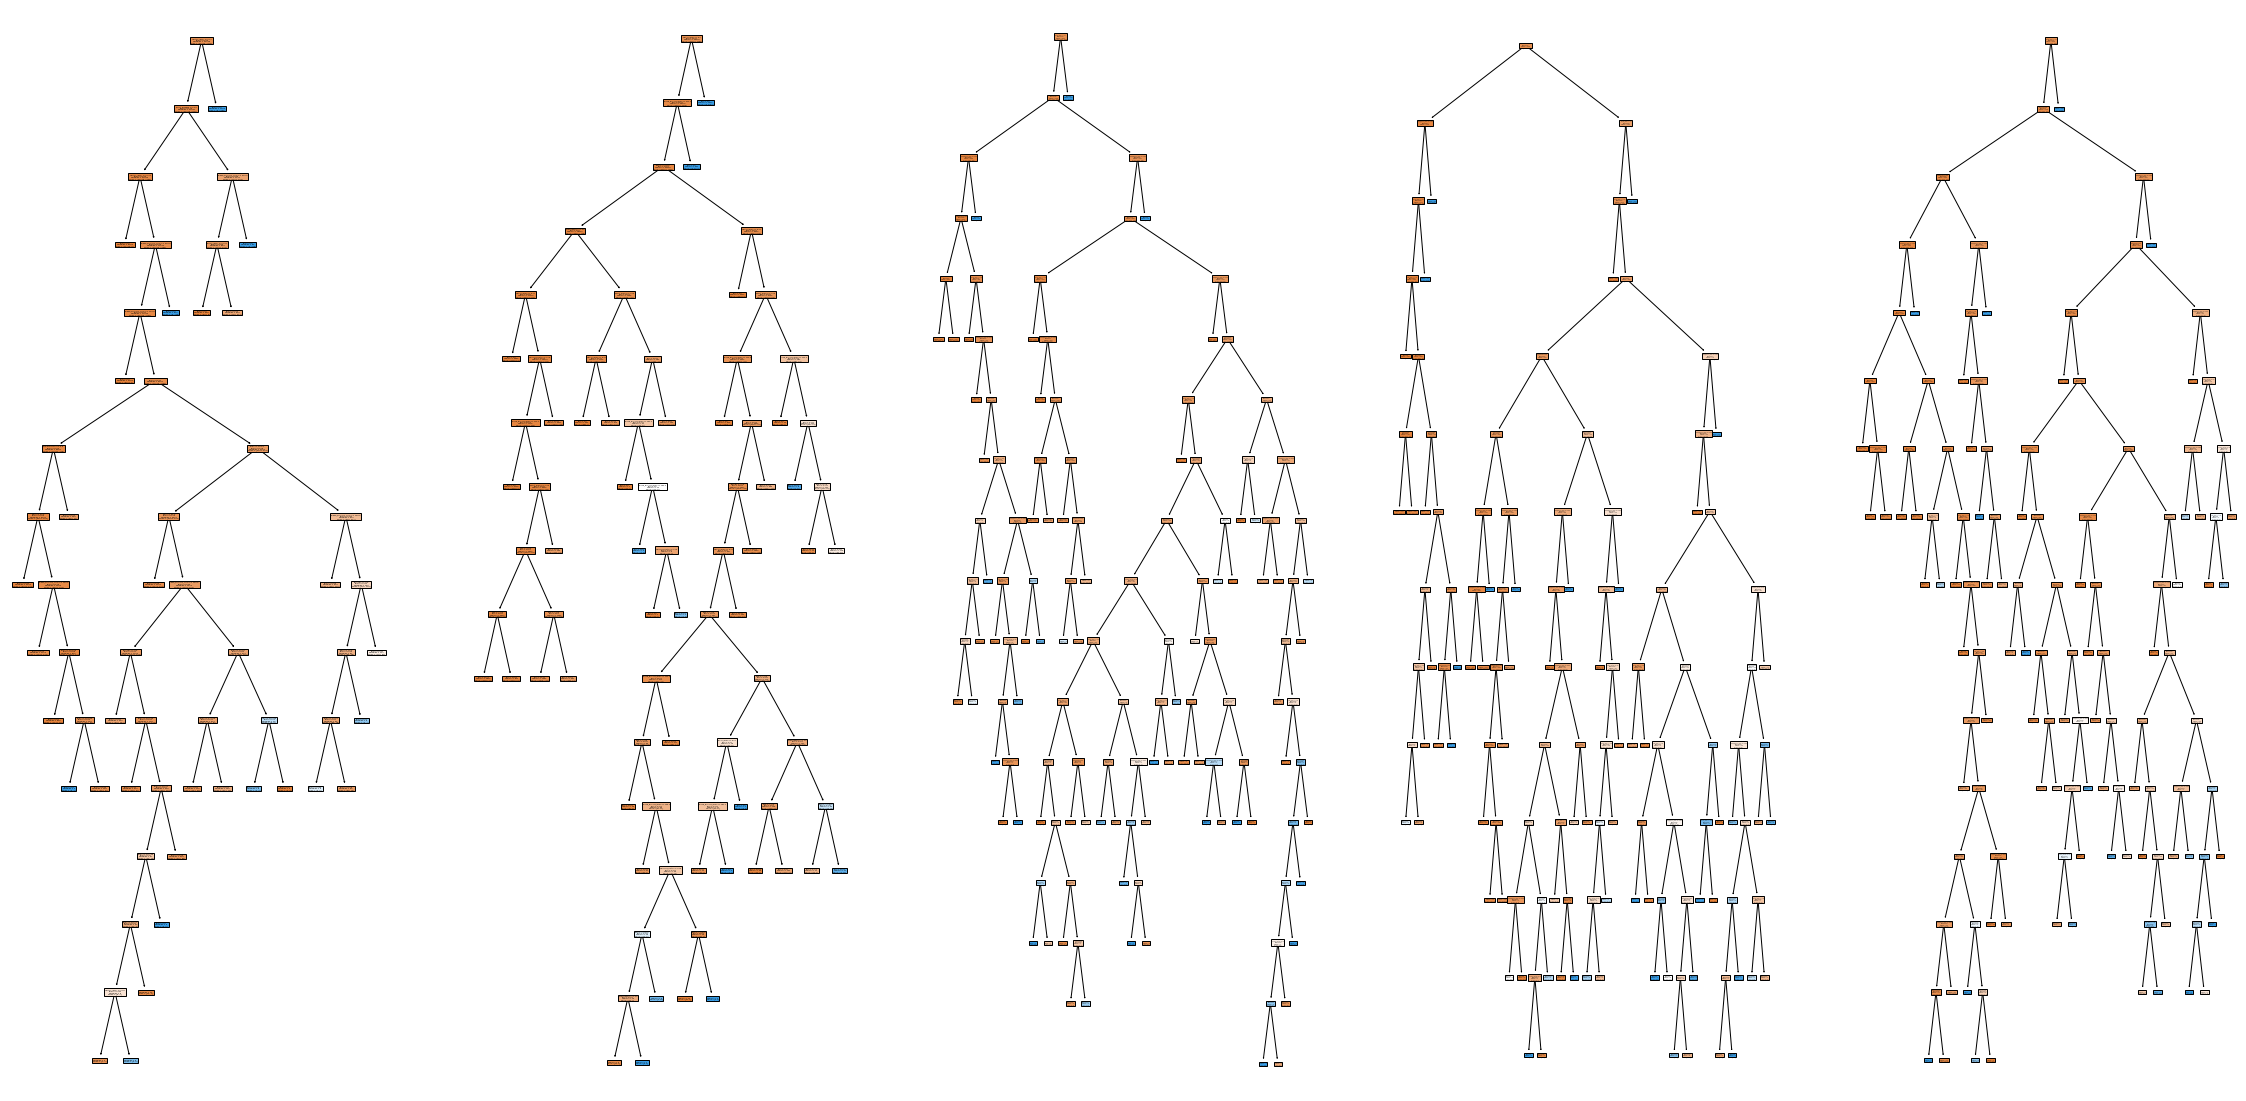

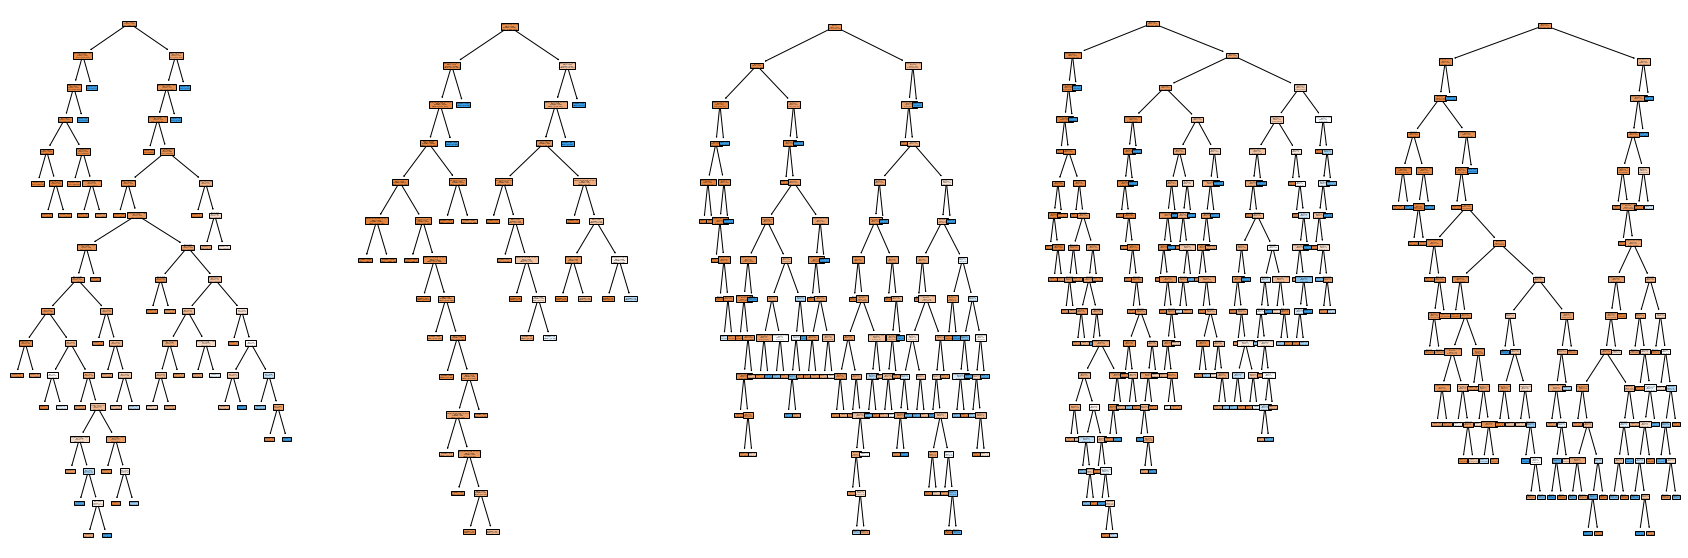

In [33]:
estims = best_estimator_opt.estimators_

#Randomly choose 10 decision trees to display
random_nums = random.sample(range(0, len(estims)), 10)
fig, axes = plt.subplots(nrows = 1, ncols = 5,figsize = (40,20))

feature_names = []
for i in range(0, len(X.columns), 1):
    feature_name = X.columns[i]
    feature_names.append(feature_name)
    
print(type(feature_names))

print(random_nums)
for i in range(0, 5, 1):
    tree.plot_tree(estims[random_nums[i]], feature_names=feature_names, filled=True, ax = axes[i])
    
fig, axes = plt.subplots(nrows = 1, ncols = 5,figsize = (30,10))
for i in range(5, 10, 1):
    tree.plot_tree(estims[random_nums[i]], feature_names=feature_names, filled=True, ax = axes[i-5])

# ENSEMBLE COMBINATION

In [34]:
#Combine metrics from all models into lists for each metric type
ensemble_accuracies = [NN_accuracy[0], MLP_accuracy, float(LR_accuracy), float(RFC_accuracy)]
ensemble_f1 = [NN_f1[0], MLP_f1, float(LR_f1), float(RFC_f1)]
ensemble_precision = [NN_precision[0], MLP_precision, LR_precision, RFC_precision]
ensemble_recall = [NN_recall[0], MLP_recall, LR_recall, RFC_recall]

#Get errors of each metric in ensemble metrics lists by subtracting each metric from 1
ensemble_accuracy_errors = [1-acc for acc in ensemble_accuracies]
ensemble_f1_errors = [1-f1 for f1 in ensemble_f1]
ensemble_precision_errors = [1-prec for prec in ensemble_precision]
ensemble_recall_errors = [1-rec for rec in ensemble_recall]

# Combine the errors into a list where each element is the combined error for a given model
summed_errors = [
    acc_err + f1_err + prec_err + rec_err 
    for acc_err, f1_err, prec_err, rec_err 
    in zip(ensemble_accuracy_errors, ensemble_f1_errors, ensemble_precision_errors, ensemble_recall_errors)
]

#Take the inverse of errors, accounting for cases where error is 0
inverse_summed_errors = [1/err if err != 0 else 0 for err in summed_errors]

#Normalize the errors by dividing each model's summed error by the total to get weights
total_inverse_summed_errors = sum(inverse_summed_errors)
weights = [inv_err/total_inverse_summed_errors for inv_err in inverse_summed_errors]

#Take the predictions we made with each of the models on the check ensemble set, and using the weights, combine into one probability for each data point
ensemble_predictions = [
    float(NN_check_probabilities[i][0] * weights[0] + 
          MLP_check_probabilities[i] * weights[1] +
          LR_check_probabilities[i] * weights[2] +
          RFC_check_probabilities[i] * weights[3])
    for i in range(len(NN_check_probabilities))
]

#print(ensemble_predictions)

In [35]:
#Debugging print statements to double check metrics (can delete)
print(ensemble_accuracies)
print(ensemble_f1)
print(ensemble_precision)
print(ensemble_recall)

print((NN_recall))
print((MLP_recall))
print((LR_recall))
print((RFC_recall))

[0.9592813696778554, 0.9535931516107231, 0.948073890515882, 0.9623789141698581]
[0.7813728454792864, 0.7418546365914785, 0.728023598820059, 0.7958435207823961]
[0.96274217585693, 0.9649551752241239, 0.8659649122807017, 0.9961744452945677]
[0.6575063613231552, 0.6025445292620865, 0.6279898218829516, 0.6625954198473283]
[0.6575063613231552]
0.6025445292620865
0.6279898218829516
0.6625954198473283


In [36]:
#Set the probability threshold for predicting if a data point has diabetes or not (0.6-0.65 tend to have the best overall results)
threshold = 0.6

#To determine ensemble metrics, change from probabilities to discrete class predictions
ensemble_y_pred = [1 if prob > threshold else 0 for prob in ensemble_predictions]

#Calculate metrics for the combined ensemble method
ensemble_accuracy = accuracy_score(y_check_ensemble, ensemble_y_pred)
ensemble_f1 = f1_score(y_check_ensemble, ensemble_y_pred)
ensemble_precision = precision_score(y_check_ensemble, ensemble_y_pred)
ensemble_recall = recall_score(y_check_ensemble, ensemble_y_pred)

print("Ensemble Accuracy:", ensemble_accuracy)
print("Ensemble F1 Score:", ensemble_f1)
print("Ensemble Precision:", ensemble_precision)
print("Ensemble Recall:", ensemble_recall)


Ensemble Accuracy: 0.9644
Ensemble F1 Score: 0.7977272727272727
Ensemble Precision: 0.9887323943661972
Ensemble Recall: 0.6685714285714286


In [37]:
#Combine probability predictions for each 
NN_probs = [prob[0] for prob in NN_check_probabilities]
MLP_probs = MLP_check_probabilities.tolist()
LR_probs = LR_check_probabilities.tolist()
RFC_probs = RFC_check_probabilities.tolist()


df_probs = pd.DataFrame({
    "True Value": y_check_ensemble.values.ravel(),
    "NN Probabilities": NN_probs,
    "MLP Probabilities": MLP_probs,
    "LR Probabilities": LR_probs,
    "RFC Probabilities": RFC_probs,
    "Ensemble Probabilities": ensemble_predictions
})

df_probs.tail(25)

,True Value,NN Probabilities,MLP Probabilities,LR Probabilities,RFC Probabilities,Ensemble Probabilities
4975,1,0.828968,0.999368,0.971203,0.985431,0.943824
4976,0,0.202710,0.026898,0.025697,0.020118,0.071752
4977,1,0.828968,0.995491,0.818250,0.959819,0.903855
4978,1,0.828968,0.950569,0.904168,0.983103,0.917979
4979,0,0.169914,0.004014,0.007453,0.016811,0.052918
4980,0,0.008857,0.000027,0.000026,0.003685,0.003466
4981,0,0.047908,0.007440,0.053948,0.046957,0.039475
4982,0,0.047507,0.002594,0.010351,0.016913,0.020429
4983,0,0.046207,0.001087,0.015382,0.017482,0.020935
4984,0,0.363782,0.121709,0.076543,0.138796,0.182251


In [38]:
#Combine the scores of each model (including ensemble) into a table for comparison
metrics_data = {
    'Model': ['NN', 'MLP', 'LR', 'RFC', 'Ensemble'],
    'Accuracy': [NN_accuracy[0], MLP_accuracy, LR_accuracy, RFC_accuracy, ensemble_accuracy],
    'F1 Score': [NN_f1[0], MLP_f1, LR_f1, RFC_f1, ensemble_f1],
    'Precision': [NN_precision[0], MLP_precision, LR_precision, RFC_precision, ensemble_precision],
    'Recall': [NN_recall[0], MLP_recall, LR_recall, RFC_recall, ensemble_recall]
}

df_metrics = pd.DataFrame(metrics_data)

print(df_metrics)

      Model  Accuracy  F1 Score  Precision    Recall
0        NN  0.959281  0.781373   0.962742  0.657506
1       MLP  0.953593  0.741855   0.964955  0.602545
2        LR  0.948074  0.728024   0.865965  0.627990
3       RFC  0.962379  0.795844   0.996174  0.662595
4  Ensemble  0.964400  0.797727   0.988732  0.668571


In [39]:
print("ensemble_y_pred", len(ensemble_y_pred))
print("Ensemble classification report:\n")
target_names = ['Negative', 'Positive']
confusion_ensemble = classification_report(y_check_ensemble, ensemble_y_pred, target_names = target_names)
print(confusion_ensemble)

ensemble_y_pred 5000
Ensemble classification report:

              precision    recall  f1-score   support

    Negative       0.96      1.00      0.98      4475
    Positive       0.99      0.67      0.80       525

    accuracy                           0.96      5000
   macro avg       0.98      0.83      0.89      5000
weighted avg       0.97      0.96      0.96      5000

